In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from erp_classifier import stupid_clf

In [61]:
X_train = np.load('Cz_dataset/X_train.npy')
X_test = np.load('Cz_dataset/X_test.npy')
y_train = np.load('Cz_dataset/y_train.npy')
y_test = np.load('Cz_dataset/y_test.npy')

In [4]:
def get_peak(signal):
    return find_peaks(signal)

In [5]:
clf = stupid_clf()

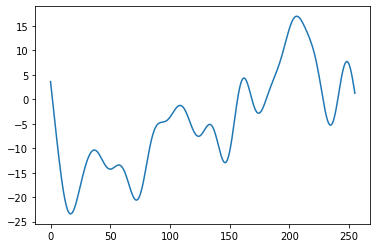

In [10]:
plt.plot(clf.preprocess(X_train[0], upper = 10))

[ 17  50  72 124 146 174 235]
label =  1.0


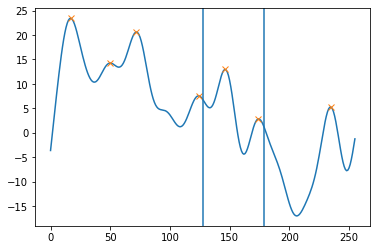

[ 45  87 109 134 179 233]
label =  1.0


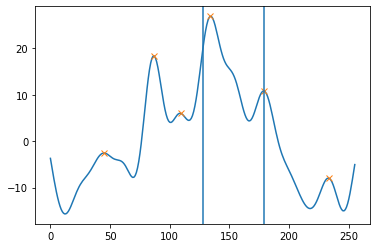

[  7  75 107 133 165 196 219 248]
label =  1.0


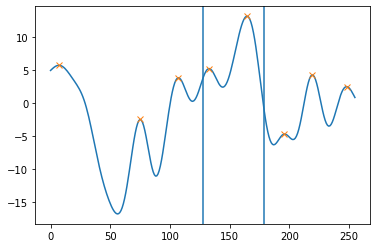

[ 16  46  81 115 178 210]
label =  0.0


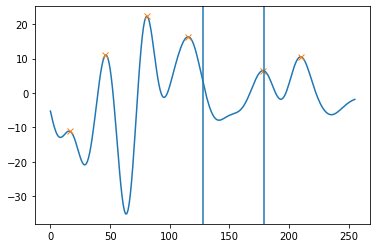

[ 24  69 108 128 157 183 246]
label =  0.0


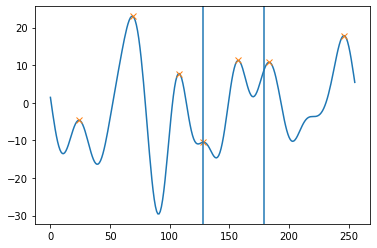

[ 16  55  97 127 171 201 228]
label =  0.0


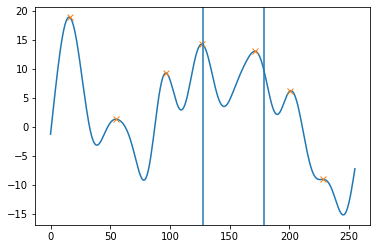

[ 12  46  73 103 167 200 210]
label =  0.0


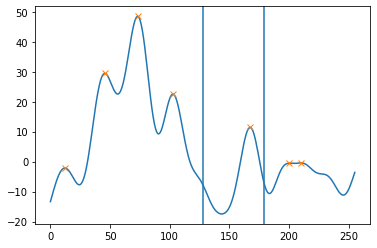

[ 17  49  76 112 156 200]
label =  0.0


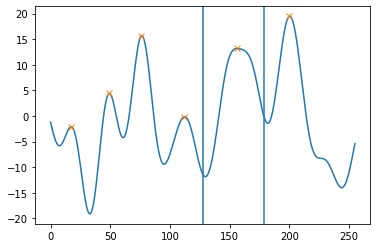

[ 20  47  79 126 189 225 248]
label =  0.0


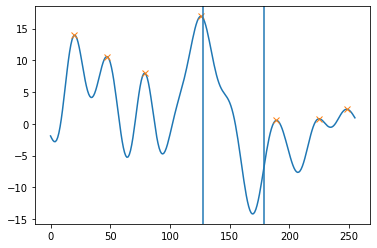

[ 25  47  79 117 165 213 249]
label =  0.0


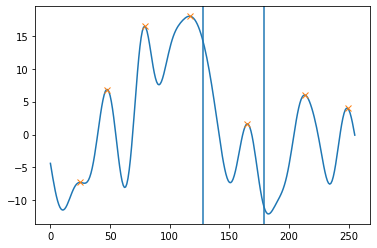

In [74]:
for i in range(10):
    peaks = find_peaks(-clf.preprocess(X_train[i], upper = 10))
    print(peaks[0])
    print("label = ", y_train[i])
    plt.plot(-clf.preprocess(X_train[i], upper = 10))
    plt.plot(peaks[0], -clf.preprocess(X_train[i], upper = 10)[peaks[0]], 'x')
    plt.axvline(x = 0.5*256)
    plt.axvline(x = 0.7*256)
    plt.show()

Actually looks pretty good. We can pick the max amplitude peak in the interval.

In [75]:
peak_hit_dataset = []
peak_miss_dataset = []

for i in range(len(X_train)):
    sample = -clf.preprocess(X_train[i], upper = 10)
    peaks, _ = find_peaks(sample)
    peaks = peaks[peaks < 256*(clf.offset + 0.5)]
    peaks = peaks[peaks > 256*(clf.offset + 0.3)]
    
    if len(peaks) == 0:
        peaks = [0.6*256, -20]
    else:
        max_p = peaks[0]
        for p in peaks[1:]:
            if sample[p] > max_p:
                max_p = p
                
        peaks = [max_p, sample[max_p]]
    
    if y_train[i] == 1:
        peak_hit_dataset.append(peaks)
    else:
        peak_miss_dataset.append(peaks)    

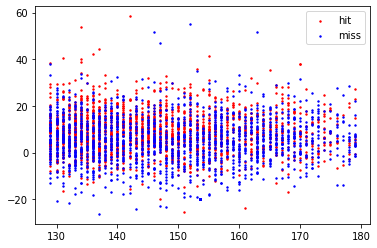

In [76]:
hit_offset, hit_val = np.array(peak_hit_dataset).T
miss_offset, miss_val = np.array(peak_miss_dataset).T
plt.scatter(hit_offset, hit_val, label = "hit", color = 'r', s = 2)
plt.scatter(miss_offset, miss_val, label = "miss", color = 'b', s = 2)
plt.legend()

In [57]:
peak_dataset = []

for i in range(len(X_train)):
    sample = -clf.preprocess(X_train[i], upper = 10)
    peaks, _ = find_peaks(sample)
    peaks = peaks[peaks < 256*(clf.offset + 0.5)]
    peaks = peaks[peaks > 256*(clf.offset + 0.3)]
    
    if len(peaks) == 0:
        peaks = [0.6*256, -20]
    else:
        max_p = peaks[0]
        for p in peaks[1:]:
            if sample[p] > max_p:
                max_p = p
                
        peaks = [max_p, sample[max_p]]
    

    peak_dataset.append(peaks)  

In [58]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(peak_dataset, y_train)

SVC()

In [59]:
peak_test_dataset = []

for i in range(len(X_test)):
    sample = -clf.preprocess(X_test[i], upper = 10)
    peaks, _ = find_peaks(sample)
    peaks = peaks[peaks < 256*(clf.offset + 0.5)]
    peaks = peaks[peaks > 256*(clf.offset + 0.3)]
    
    if len(peaks) == 0:
        peaks = [0.6*256, -20]
    else:
        max_p = peaks[0]
        for p in peaks[1:]:
            if sample[p] > max_p:
                max_p = p
                
        peaks = [max_p, sample[max_p]]
    

    peak_test_dataset.append(peaks)  

In [62]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, svc.predict(peak_test_dataset) )
print("Accuracy:", accuracy)

Accuracy: 0.5869809203142536


In [83]:
from erp_classifier import classifier

class peak_SVC(classifier):
    def __init__(self):
        super().__init__()
        self.model = SVC()
        
    def preprocess(self, x):
        peak_dataset = []

        for i in range(len(x)):
            sample = -super().preprocess(x[i], upper = 10)
            peaks, _ = find_peaks(sample)
            peaks = peaks[peaks < self.sampling_rate*(self.offset + 0.5)]
            peaks = peaks[peaks > self.sampling_rate*(self.offset + 0.3)]

            if len(peaks) == 0:
                peaks = [0.6*256, -20]
            else:
                max_p = peaks[0]
                for p in peaks[1:]:
                    if sample[p] > max_p:
                        max_p = p

                peaks = [max_p, sample[max_p]]


            peak_dataset.append(peaks)
            
        return peak_dataset

    def predict(self, X):
        return self.model.predict(self.preprocess(X))

    def train_model(self, train_X, train_y):
        self.model.fit(self.preprocess(train_X), train_y)

Accuracy: 0.5869809203142536
Confusion Matrix:
[[173 286]
 [ 82 350]]


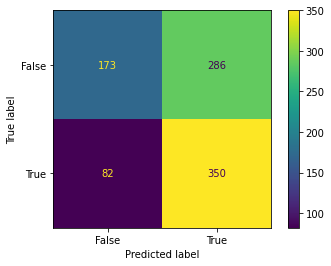

(0.5869809203142536,
 array([[173, 286],
        [ 82, 350]]))

In [84]:
pk = peak_SVC()
pk.train_model(X_train, y_train)
pk.test(X_test, y_test)